<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Gaussian elimination

## Contents

In this notebook, we will learn

- How to parallelize Gaussian elimination
- How the data partition can create (or solve) load imbalances

## Gaussian elimination

[Gaussian elimination](https://en.wikipedia.org/wiki/Gaussian_elimination) is provably one of the first algorithms you have learned to solve linear equations like this one:

$$
\left[
\begin{matrix}
1 & 3 & 1 \\
1 & 2 & -1 \\
3 & 11 & 5 \\
\end{matrix}
\right]
\left[
\begin{matrix}
x \\
y \\
z  \\
\end{matrix}
\right]
=
\left[
\begin{matrix}
9 \\
1 \\
35  \\
\end{matrix}
\right]
$$


The value of $x$, $y$, and $z$ can be found by creating an *augmented matrix* and applying Gaussian elimination to it:

$$
\left[
\begin{matrix}
1 & 3 & 1 & 9 \\
1 & 2 & -1 & 1 \\
3 & 11 & 5 & 35 \\
\end{matrix}
\right]
\rightarrow
\left[
\begin{matrix}
1 & 3 & 1 & 9 \\
0 & -1 & -2 & -8 \\
0 & 2 & 2 & 8 \\
\end{matrix}
\right]
\rightarrow
\left[
\begin{matrix}
1 & 3 & 1 & 9 \\
0 & 1 & 2 & 8 \\
0 & 0 & 1 & 4 \\
\end{matrix}
\right]
$$

The result is an upper diagonal matrix with ones on the diagonal. From this matrix the values $x$, $y$, and $z$ can be found via [backward substitution](https://en.wikipedia.org/wiki/Triangular_matrix).



### Serial implementation

Gaussian elimination can be implemented as shown in the following function. Note that the result is overwritten in-place on the input matrix.

In [70]:
function gaussian_elimination!(B)
    n,m = size(B)
    @inbounds for k in 1:n
        for t in (k+1):m
            B[k,t] =  B[k,t]/B[k,k]
        end
        B[k,k] = 1
        for i in (k+1):n 
            for j in (k+1):m
                B[i,j] = B[i,j] - B[i,k]*B[k,j]
            end
            B[i,k] = 0
        end
    end
    B
end

gaussian_elimination! (generic function with 2 methods)

Let us test the function with the example above:

In [68]:
A = Float64[1 3 1; 1 2 -1; 3 11 5]
b = Float64[9,1,35]
B = [A b]

3×4 Matrix{Float64}:
 1.0   3.0   1.0   9.0
 1.0   2.0  -1.0   1.0
 3.0  11.0   5.0  35.0

In [71]:
gaussian_elimination!(B)

3×4 Matrix{Float64}:
 1.0  3.0  1.0  9.0
 0.0  1.0  2.0  8.0
 0.0  0.0  1.0  4.0

We get the same result as shown before (as expected).

## Parallelization

Gaussian elimination is expensive and thus it makes sense to try to seed-up this computation by using several processors. It requires $(2n^3)/3$ operation, where $n$ is the number of rows in the input matrix. Thus, the time complexity is $O(n^3)$, which rapidly grows with $n$.


### Where can we extract parallelism?

```julia
n,m = size(B)
for k in 1:n
    for t in (k+1):m
        B[k,t] =  B[k,t]/B[k,k]
    end
    B[k,k] = 1
    for i in (k+1):n 
        for j in (k+1):m
            B[i,j] = B[i,j] - B[i,k]*B[k,j]
        end
        B[i,k] = 0
    end
end
```

- The loop over k cannot be parallelized (the state of B at iteration k depends on the state at iteration k-1)
- Loops over t, i, and j can be parallelized
- BUT the loop over t needs to be done before loop over i and j

### Data partition

Let us start considering a simple 1D block partition. We assume that each process contains only a portion of the input matrix consisting in a block of consecutive rows. In this algorithm, the data stored in a process does not correspond with the data updated at a given iteration over the outer loop over k. The data updated is only a subset of the data stored, which leads to load imbalances (as we will see in a second).

Consider next figure. Let's find out which is the data updated and the data used by CPU 3 at iteration $k$.


<div>
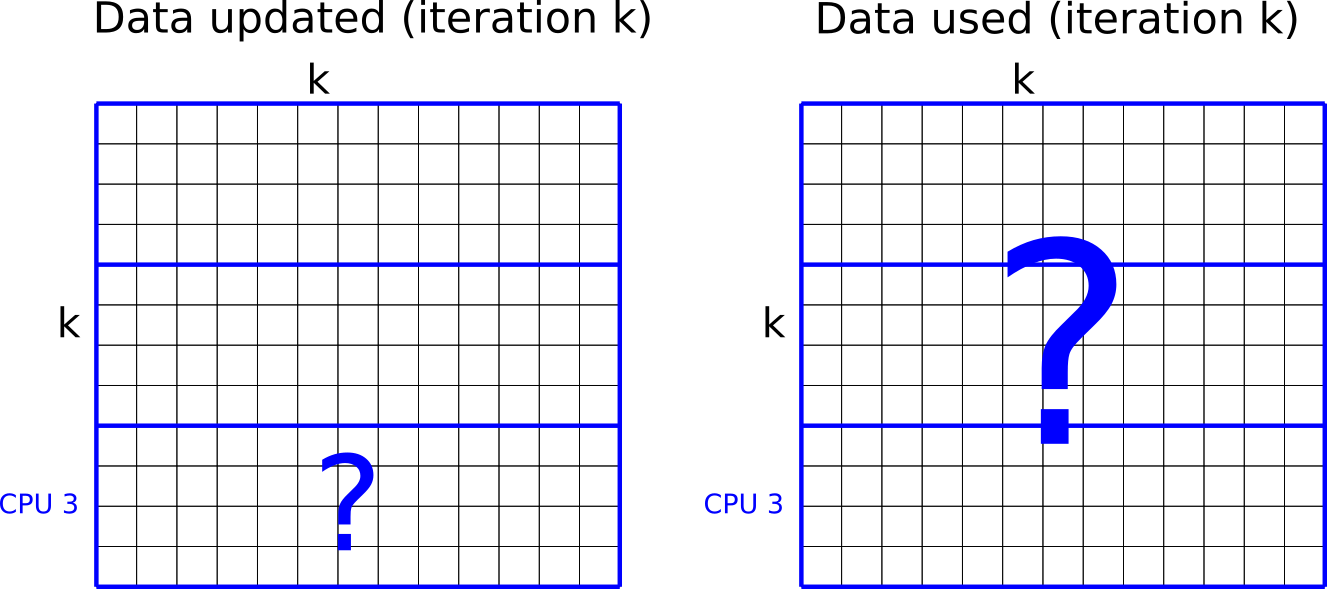
</div>

By looking into the code above, you can see that `B[i,j]` is updated at iteration k, if and only if i and j are greater or equal than k. Thus, from all entries owned by CPU3, only the ones fulfilling this condition will be updated. See the entries highlighted in the next figure.

<div>
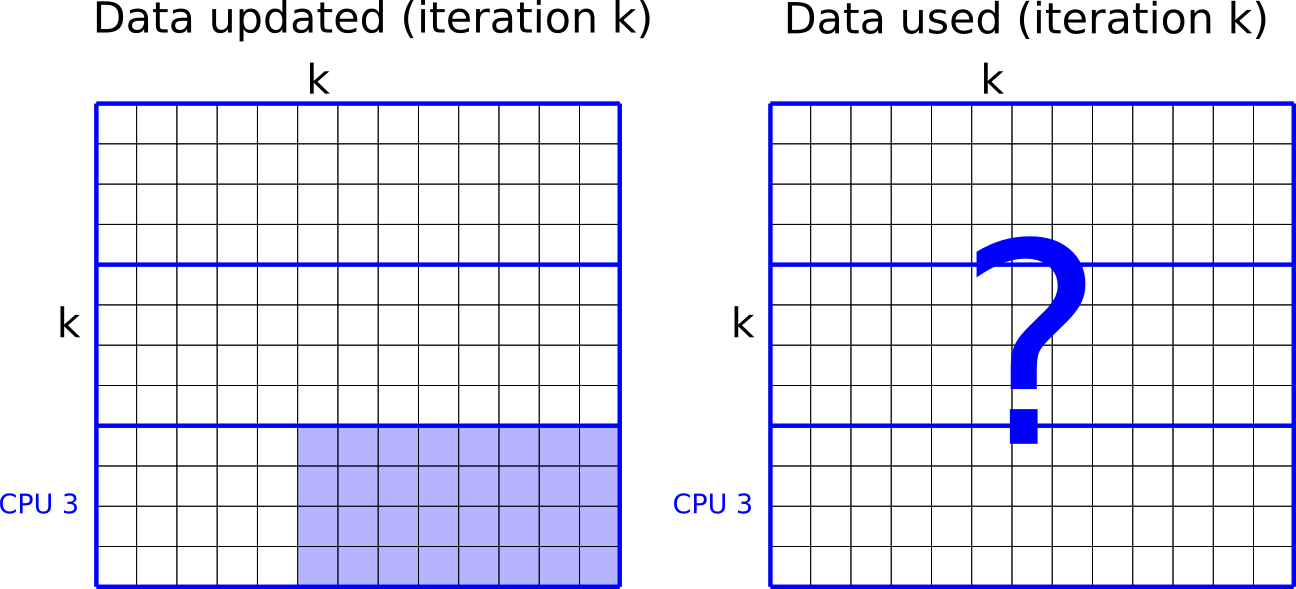
</div>

### Data dependencies

At iteration k, CPU3 needs part of row k to update its entries. The process owning row k needs to broadcast this entries to all other processes that require them. This communication pattern is almost identical to the one previously studied in Floyd's algorithm.

<div>
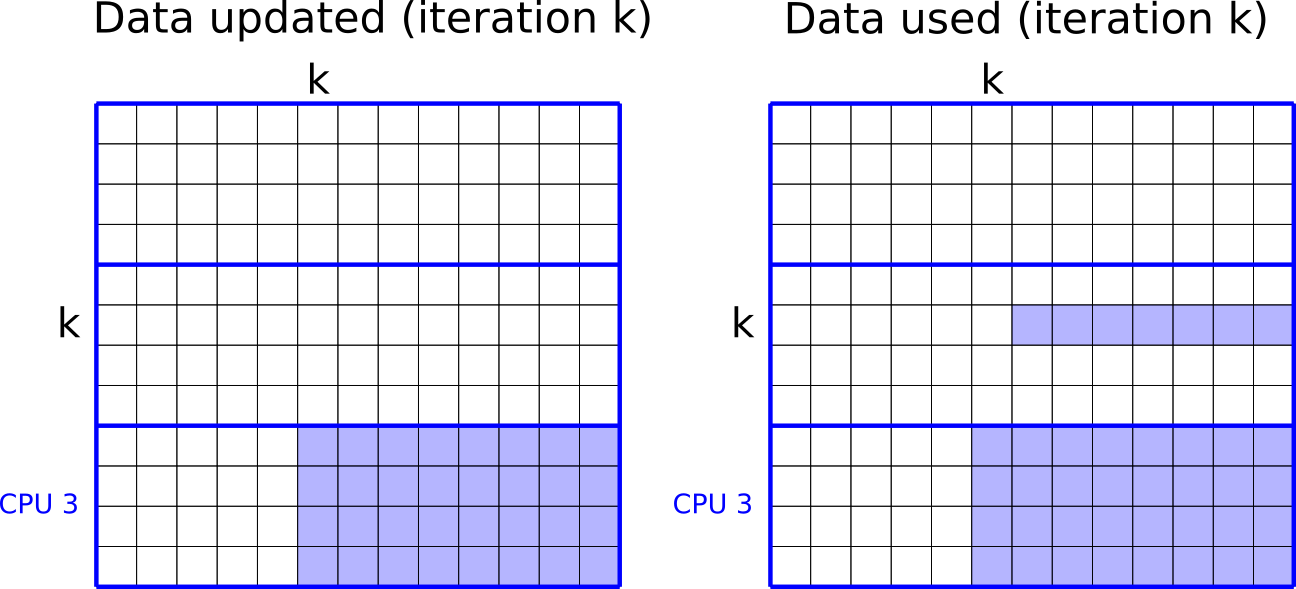
</div>

### Load imbalance

Do all processes process the same amount of data at a given iteration? This answer is no. To understand this let us find out the data updated by CPU1 in the figure below. At iteration k, CPU 1 has not data to process since k is larger than all row ids that CPU 1 owns. This is in contrast to CPU 2 and CPU 3 which have data to process. As a result, CPU 1 is idle (doing nothing), which is waisting computational resources that could be otherwise used.

<div>
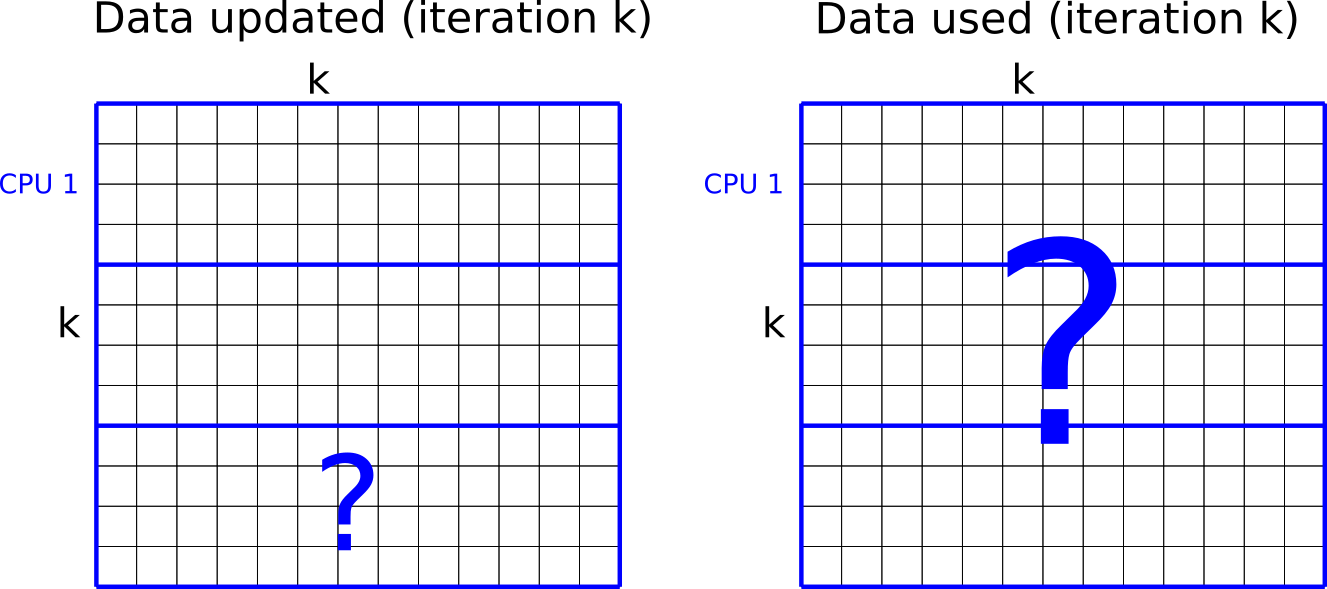
</div>

### Addressing the load imbalance

For this algorithm, a cyclic distribution mitigates the load imbalance.

- Cyclic partitions are often useful in algorithms with *predictable* load imbalance
- A cyclic partition is a form of *static* load balancing
- Cyclic partition are not suitable for all communication patters. E.g., algorithms that require communication between nearest-neighbors like Jacobi.

<div>
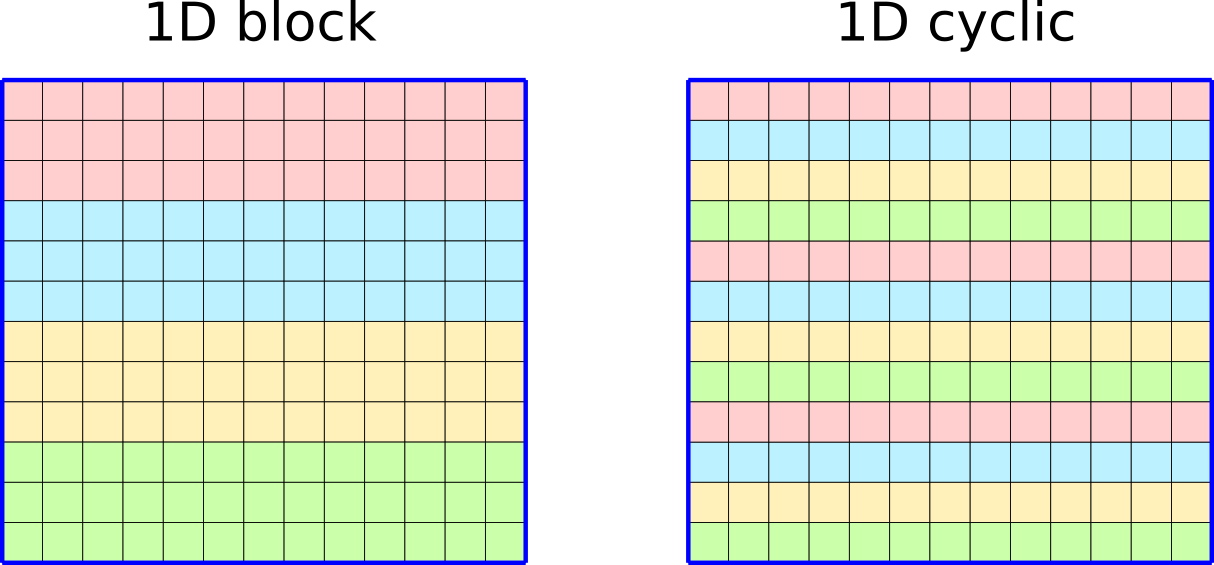
</div>